In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
classLabels = ["exotic", "cozy", "luxurious", "nature_freindly", "modern" ]

print(torch.__version__)

2.2.1+cu121


In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [3]:
!unzip -q -o data.zip

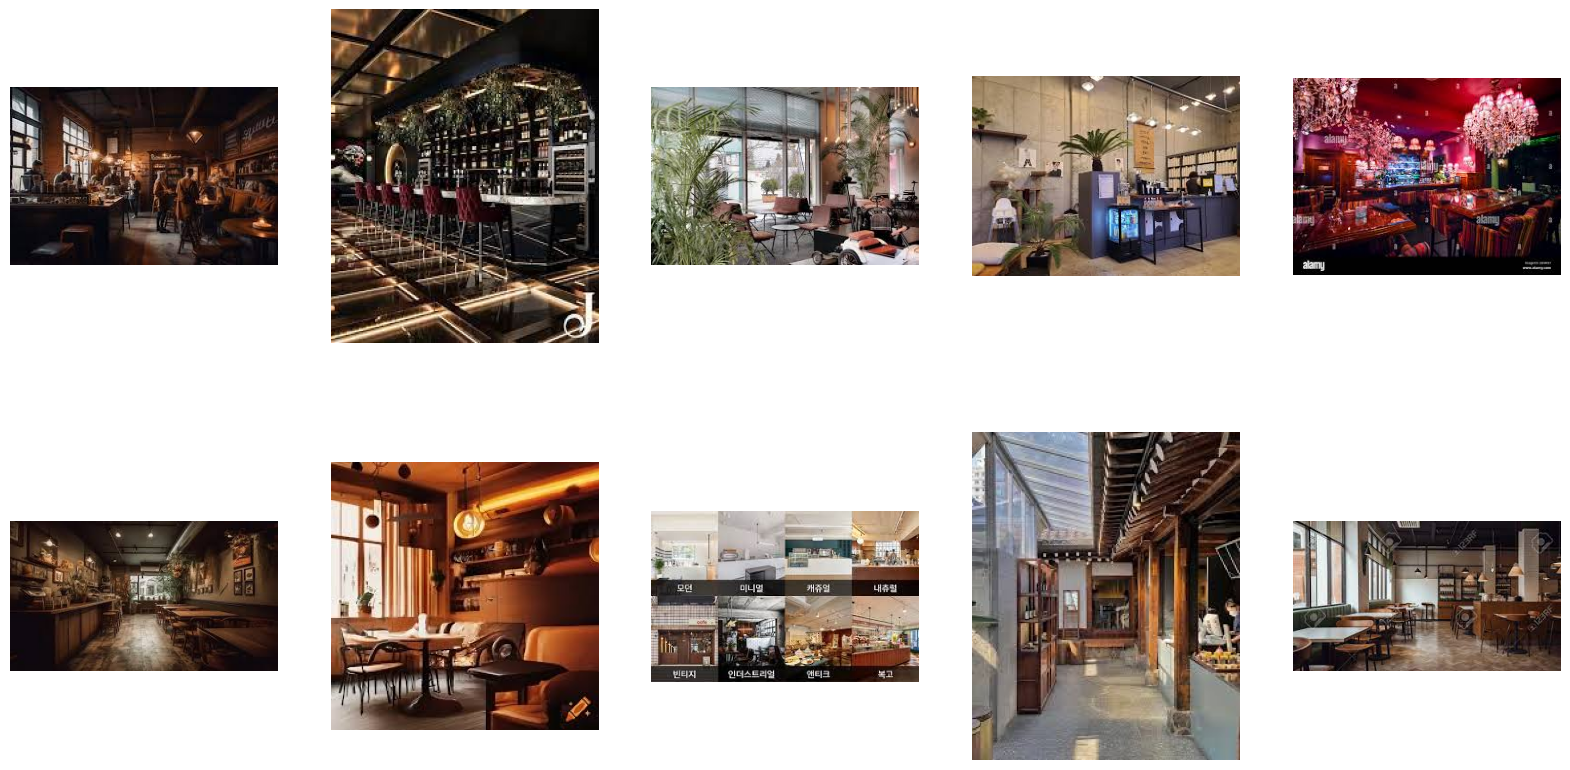

In [4]:
import os
import random

image_folder_path = 'original'

# 폴더 내의 모든 파일 목록을 가져옵니다.
image_files = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]

# 랜덤하게 10개의 이미지를 선택합니다. (이미지 수가 10개 미만일 경우 모든 이미지를 선택)
selected_images = random.sample(image_files, min(10, len(image_files)))

# 선택된 이미지를 출력합니다.
plt.figure(figsize=(20, 10))  # 출력될 이미지 크기를 설정합니다.
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)  # 2행 5열의 그리드에서 이미지를 출력합니다.
    plt.imshow(img)
    plt.axis('off')  # 축을 보이지 않게 합니다.
plt.show()

In [11]:
df = pd.DataFrame({"image": sorted([ int(x.name.strip(".jpg")) for x in Path("original").iterdir()])})
df.image = df.image.astype( str)
print(df.dtypes)
df.image = df.image.str.cat([".jpg"]*len(df))
for label in classLabels:
  df[label]=0
with open("labels.json") as infile:
    s ="["
    s = s + ",".join(infile.readlines())
    s = s+"]"
    s = np.array(eval(s))
    s[s<0] = 0
    df.iloc[:,1:] = s
df.to_csv("data.csv",index=False)
print(df.head(10))
print(df.tail(10))

image    object
dtype: object
    image  exotic  cozy  luxurious  nature_freindly  modern
0   1.jpg       1     0          0                0       0
1   2.jpg       1     0          0                0       0
2   3.jpg       1     0          0                0       0
3   4.jpg       1     0          0                0       0
4   5.jpg       1     0          0                0       0
5   6.jpg       1     0          0                0       0
6   7.jpg       1     0          0                0       0
7   8.jpg       1     0          0                0       0
8   9.jpg       1     0          0                0       0
9  10.jpg       1     0          0                0       0
       image  exotic  cozy  luxurious  nature_freindly  modern
365  366.jpg       1     1          0                1       0
366  367.jpg       1     1          0                0       0
367  368.jpg       1     0          0                0       0
368  369.jpg       1     1          0                0    

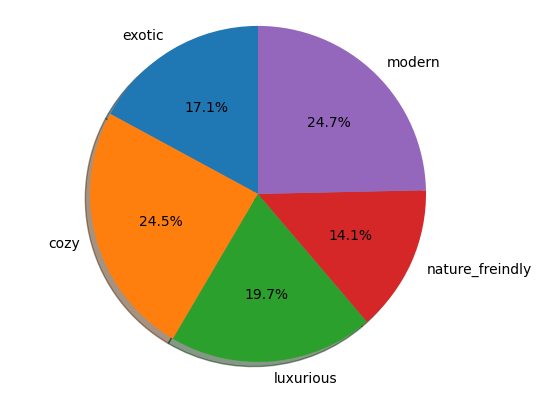

In [12]:
df = pd.read_csv("data.csv")
fig1, ax1 = plt.subplots()
df.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

52.jpg


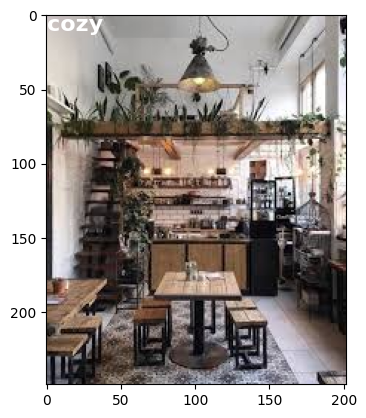

In [13]:
def visualizeImage(idx):
    fd = df.iloc[idx]
    image = fd['image']
    label = fd[1:].to_numpy()
    print(image)
    image = Image.open("original/" + image)
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    classes = np.array(classLabels)[label.astype(np.bool_)]  # np.bool 대신 np.bool_ 사용
    for i, s in enumerate(classes):
        ax.text(0, i * 20, s, verticalalignment='top', color="white", fontsize=16, weight='bold')
    plt.show()

visualizeImage(51)

In [14]:
#데이터 셋 내의 이미지 크기가 달라서 한번 출력해 봄
l= []
for i in df.image:
  with Image.open(Path("original")/i) as f:
    l.append(f.size)

np.array(l).mean(axis=0),np.median(np.array(l) , axis=0)

(array([298.024     , 248.61066667]), array([275., 189.]))

In [15]:
#데이터 피딩을 위한 작업

class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):

    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms

  def __getitem__(self,idx):
    d = self.df.iloc[idx]
    image = Image.open(self.img_dir/d.image).convert("RGB")
    label = torch.tensor(d[1:].tolist() , dtype=torch.float32)

    if self.transforms is not None:
      image = self.transforms(image)
    return image,label

  def __len__(self):
    return len(self.df)

In [16]:
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) ,
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dataset = MyDataset("data.csv" , Path("original") , transform)

# train, valid 셋 구분

valid_no = int(len(dataset)*0.12)
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])
print(f"trainset len {len(trainset)} valset len {len(valset)}")
dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

trainset len 330 valset len 45


In [17]:
# resnet50모델로 전이학습 하겠습니다.

model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


2048


In [18]:
# 우리 목적에 맞게 resnet 머리(fully connected layer)를 만들어 줍니다.

def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
top_head = create_head(num_features , len(classLabels)) # because ten classes
top_head = top_head.to(device)
model.fc = top_head # replace the fully connected layer

cpu


In [19]:
#모델을 출력해 봅니다.

from torchvision import models
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
#다른 방법으로 모델을 출력해 봅니다.
for name, param in model.named_parameters():
    print(f"Layer Name: {name}, Parameter Size: {param.size()}")

Layer Name: conv1.weight, Parameter Size: torch.Size([64, 3, 7, 7])
Layer Name: bn1.weight, Parameter Size: torch.Size([64])
Layer Name: bn1.bias, Parameter Size: torch.Size([64])
Layer Name: layer1.0.conv1.weight, Parameter Size: torch.Size([64, 64, 1, 1])
Layer Name: layer1.0.bn1.weight, Parameter Size: torch.Size([64])
Layer Name: layer1.0.bn1.bias, Parameter Size: torch.Size([64])
Layer Name: layer1.0.conv2.weight, Parameter Size: torch.Size([64, 64, 3, 3])
Layer Name: layer1.0.bn2.weight, Parameter Size: torch.Size([64])
Layer Name: layer1.0.bn2.bias, Parameter Size: torch.Size([64])
Layer Name: layer1.0.conv3.weight, Parameter Size: torch.Size([256, 64, 1, 1])
Layer Name: layer1.0.bn3.weight, Parameter Size: torch.Size([256])
Layer Name: layer1.0.bn3.bias, Parameter Size: torch.Size([256])
Layer Name: layer1.0.downsample.0.weight, Parameter Size: torch.Size([256, 64, 1, 1])
Layer Name: layer1.0.downsample.1.weight, Parameter Size: torch.Size([256])
Layer Name: layer1.0.downsample

In [21]:
# 모델의 바닥 일부를 freezing합니다.
# 'conv1', 'bn1', 'relu', 'maxpool', 'layer1'을 포함한 초기 레이어를 freeze

for name, child in model.named_children():
    if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']:
        for param in child.parameters():
            param.requires_grad = False
    else:
        break  # 'layer1' 다음 레이어에 도달하면 loop 종료


In [22]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [23]:
#loss 함수와 옵티마이져, 스케줄로를 정의합비다.
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [24]:
# 정확도 값으로 f1_스코어를 사용하고 있네요
# tqdm은 학습 진행정도를 시각화 해줍니다.

from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
        scheduler.step()
      else:     # put the model in validation mode
        model.eval()

      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0

      for data , target in data_loader[phase]:
        #load the data and target to respective device
        data , target = data.to(device)  , target.to(device)

        with torch.set_grad_enabled(phase=="train"):
          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.sigmoid(output).data > 0.5
          preds = preds.to(torch.float32)

          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # update the model parameters
            optimizer.step()
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()


        # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)


      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)

In [25]:
train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epochs:  10%|█         | 1/10 [02:29<22:27, 149.76s/it]

['train Loss: 0.7158 Acc: 0.4096', 'val Loss: 3.8196 Acc: 0.4129']


Epochs:  20%|██        | 2/10 [04:54<19:36, 147.01s/it]

['train Loss: 0.6290 Acc: 0.4983', 'val Loss: 4.9446 Acc: 0.4141']


Epochs:  30%|███       | 3/10 [07:25<17:19, 148.45s/it]

['train Loss: 0.4924 Acc: 0.6362', 'val Loss: 1.4073 Acc: 0.4422']


Epochs:  40%|████      | 4/10 [09:47<14:35, 145.99s/it]

['train Loss: 0.3846 Acc: 0.7025', 'val Loss: 1.2346 Acc: 0.4341']


Epochs:  50%|█████     | 5/10 [12:10<12:04, 144.89s/it]

['train Loss: 0.3698 Acc: 0.7553', 'val Loss: 1.1761 Acc: 0.2896']


Epochs:  60%|██████    | 6/10 [14:32<09:36, 144.18s/it]

['train Loss: 0.3183 Acc: 0.7494', 'val Loss: 1.8354 Acc: 0.4104']


Epochs:  70%|███████   | 7/10 [17:03<07:18, 146.19s/it]

['train Loss: 0.2725 Acc: 0.8193', 'val Loss: 0.8973 Acc: 0.4044']


Epochs:  80%|████████  | 8/10 [19:24<04:49, 144.65s/it]

['train Loss: 0.1926 Acc: 0.8829', 'val Loss: 0.7950 Acc: 0.4481']


Epochs:  90%|█████████ | 9/10 [21:48<02:24, 144.48s/it]

['train Loss: 0.1621 Acc: 0.9127', 'val Loss: 0.7754 Acc: 0.4259']


Epochs: 100%|██████████| 10/10 [24:07<00:00, 144.71s/it]

['train Loss: 0.1151 Acc: 0.9436', 'val Loss: 0.7905 Acc: 0.3741']


In [26]:
#모델 저장
def createCheckpoint(filename=Path("./LatestCheckpoint.pt")):
  checkpoint = {
              'epoch': 5,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
  } # save all important stuff
  torch.save(checkpoint , filename)
createCheckpoint()

In [27]:
#모델 로드 및 추론용으로 세팅
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

'''

checkpoint = torch.load(Path("./LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.0009999999999999983
    maximize: False
    weight_decay: 0
)

In [28]:
#valid 데이터로 추론

image , label = next(iter(dataloader["val"]))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
  output = model(image)
  output = torch.sigmoid(output)
output = output>0.2

In [29]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
  image = image.to("cpu").clone().detach()
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0)
  image = torch.clamp(image,0,1)
  return image.numpy()

def visualize(image , actual , pred):
  fig,ax = plt.subplots()
  ax.imshow(denormalize(image))
  ax.grid(False)
  classes =  [ classLabels[i] for i, x in enumerate(actual) if int(x) == 1 ]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')

  classes =  [ classLabels[i] for i, x in enumerate(pred) if int(x) == 1 ]
  for i , s in enumerate(classes):
    ax.text(160 , i*20  , s , verticalalignment='top', color="black", fontsize=16, weight='bold')

  plt.show()

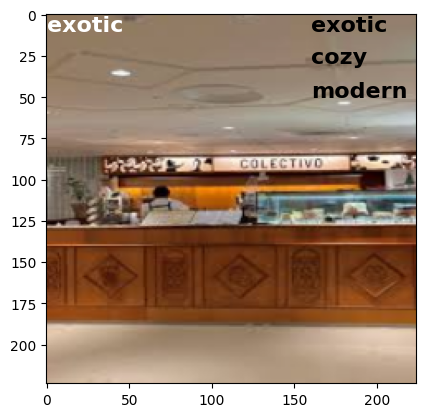

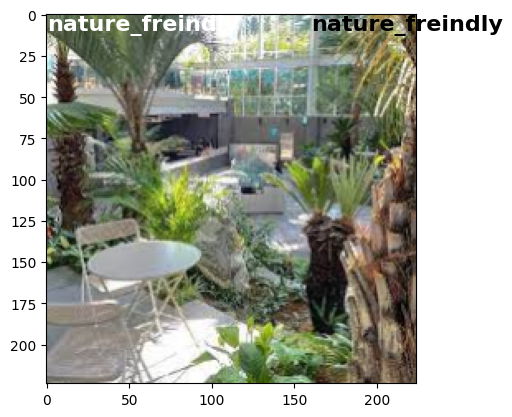

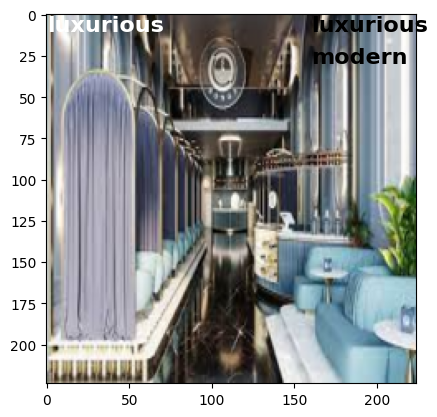

In [30]:

visualize(image[0] , label[0].tolist() , output[0].tolist())
visualize(image[1] , label[1].tolist() , output[1].tolist())
visualize(image[2] , label[2].tolist() , output[2].tolist())

In [ ]:
# 모델의 명중률 확인

def accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > 0.5
            correct += torch.sum(predictions == labels)
            total += labels.shape[0]
    return correct.item() / total


model_accuracy = accuracy(model, dataloader["val"]) * 10
print(f"Model Accuracy: {model_accuracy:.2f}%")


Model Accuracy: 40.22%
